<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/Rectifier_12pulse_diode_withTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Three-Phase 12-Pulse Diode Rectifier with Transformer</h1></b>

Dr. Bingsen Wang

4/1/2024
</center>

#Delta Winding Currents

For the delta winding currents, the following equations hold
$$\begin{align}
i_{ba2} - i_{ac2} &= i_{a2}\tag{1}\\
i_{cb2} - i_{ba2} &= i_{b2}\tag{2}
\end{align}
$$

Since there is no circulation current inside the delta winding, then we have
$$i_{ba2} + i_{cb2} + i_{ac2} =0\tag{3}$$

Adding equations (1) and (3) yields
$$2i_{ba2} +  i_{cb2} = i_{a2}\tag{4}$$

Substituting (4) into (2) yields
$$i_{ba2} = \frac{i_{a2} - i_{b2}}{3}\tag{5}$$
Then it follows that
$$i_{cb2} = \frac{i_{b2} - i_{c2}}{3}\\
i_{ac2} = \frac{i_{c2} - i_{a2}}{3}\tag{6}$$

#Python Code
The Python code illustrates waveforms of the three-phase 12-pulse diode rectifier with the input transformer.

<ipython-input-207-7c5cb352daca>:372: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


0
0
15
30
45
60
75
90
105
120
135
150
165
180
195
210
225
240
255
270
285
300
315
330
345
360
375
390
405
420
435
450
465
480
495
510
525
540
555
570
585
0


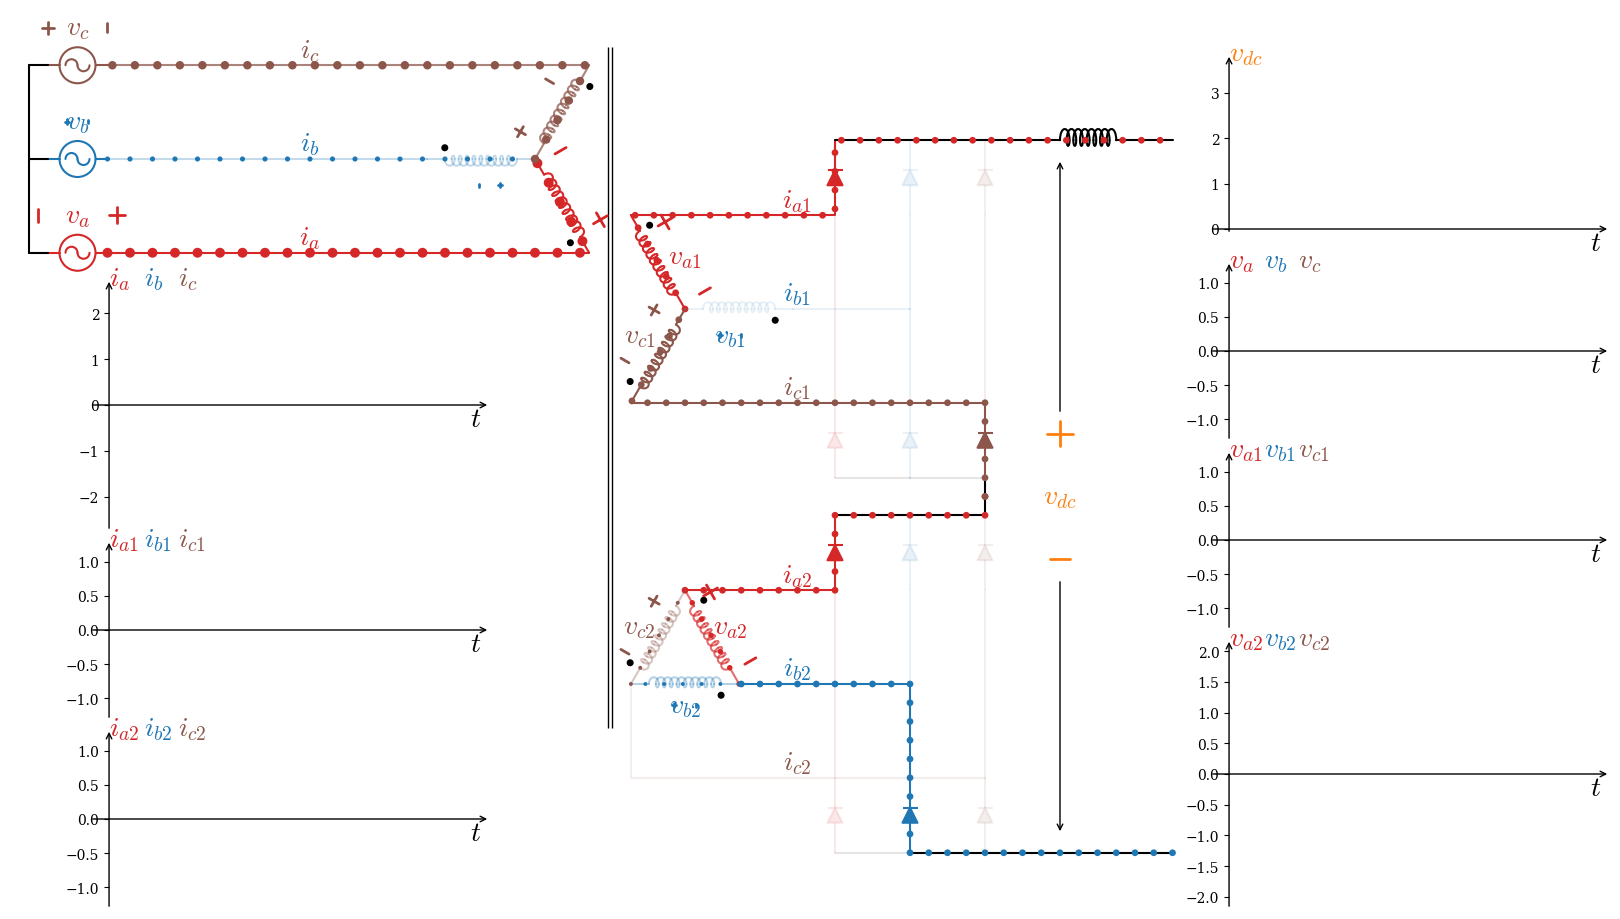

In [207]:
import matplotlib
from os import linesep
import numpy as np
from numpy import linspace,cos,sin,pi,heaviside,array,sqrt,angle,exp,sign
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba#,TABLEAU_COLORS
from matplotlib.path import Path
import matplotlib.patches as mp
from matplotlib.collections import PatchCollection
from matplotlib import animation,rc,transforms
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#modulation functions
def mf(t,f,phi):
  mta = cos(2*pi*f*t+phi)
  mtb = cos(2*pi*f*t+phi-2*pi/3)
  mtc = cos(2*pi*f*t+phi+2*pi/3)
  return [mta,mtb,mtc]

#switching functions for the high-side diodes
def hh(t,f,phi):
  ht = []
  for k in range(3):
    ht.append(heaviside(mf(t,f,phi)[k]-mf(t,f,phi)[(k+1)%3],0)*heaviside(mf(t,f,phi)[k]-mf(t,f,phi)[(k+2)%3],0))
  return ht

#switching functions for the low-side diodes
def hl(t,f,phi):
  ht = []
  for k in range(3):
    ht.append(heaviside(-mf(t,f,phi)[k]+mf(t,f,phi)[(k+1)%3],0)*heaviside(-mf(t,f,phi)[k]+mf(t,f,phi)[(k+2)%3],0))
  return ht

#ac current
def iac(t,f,phi):
  i = [] #high side current
  for k in range(3):
    i.append(hh(t,f,phi)[k] - hl(t,f,phi)[k])
  return i

#draw diode symbol
def drawDiode(ax,x0,y0,h,theta,lw,color):
  codes=[Path.MOVETO,Path.LINETO]
  p1=mp.PathPatch(Path([(x0,y0),(x0,y0+h*0.4), (x0,y0+h*0.6),(x0,y0+h)],
                       codes+codes))
  p2=mp.PathPatch(Path([(x0-h*0.1,y0+h*0.6),(x0+h*0.1,y0+h*0.6)],
                       codes)) #cathode
  p3=mp.PathPatch(Path([(x0,y0+h*0.6),(x0-h*0.1,y0+h*0.4),(x0+h*0.1,y0+h*0.4),(x0,y0+h*0.6)],
                       [Path.MOVETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY])) #anode
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  kwargs=dict({'ec':color,'fc':['none','none',color],'lw':lw,'transform':rot})
  ax.add_collection(PatchCollection([p1,p2,p3],**kwargs))
  return

#draw inductor symbol
def drawInductor(ax,x0,y0,n,h,w,theta,lw,color):
  """n: number of coils;  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical """
  w= w/(0.7*n+0.3)#width of larger coil
  plg, psm = ([],[]) #the half coil with larger curvature
  codes=[Path.MOVETO,Path.CURVE4,Path.CURVE4,Path.CURVE4]
  verts=[(x0,y0),(x0,y0+0.4*h),(x0+w,y0+0.4*h),(x0+w,y0)]
  for k in range(n):
    if k==0:
      plg.append(mp.PathPatch(Path(verts,codes)))
    else:
      p = Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0+0.4*h),
                (x0+(0.7*k+1)*w,y0+0.4*h),(x0+(0.7*k+1)*w,y0)], codes)
      plg.append(mp.PathPatch(p))
      p = Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0-0.2*h),
                (x0+(0.7*k+0.3)*w,y0-0.2*h),(x0+(0.7*k+0.3)*w,y0)], codes)
      psm.append(mp.PathPatch(p))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(np.concatenate((plg,psm)),ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw transformer winding
def drawTransformerWinding(ax,x0,y0,n,h,w,theta,lw,color,dotpos='start'):
  codes = [Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO]
  drawInductor(ax,x0+w/6*cos(theta*pi/180),y0+w/6*sin(theta*pi/180),n,h,w*2/3,theta,lw,color)
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  p = Path([(x0,y0), (x0+w/6,y0), (x0+5/6*w,y0), (x0+w,y0)], codes)
  ax.add_patch(mp.PathPatch(p,ec=color,fc='none',lw=lw,transform=rot,capstyle='round'))
  rdot = h/8 #dot radius
  if dotpos == 'start':
    dot = mp.Circle((x0+w/6,y0-4*rdot),radius=rdot,color='k',transform=rot)
  else:
    dot = mp.Circle((x0+w*5/6,y0-4*rdot),radius=rdot,color='k',transform=rot)
  ax.add_patch(dot)
  return

#draw ac voltage source symbol
def drawVoltSourceAc(ax,x0,y0,h,theta,lw,color):
  """ x0,y0: top or left end of the voltage source lead
  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical"""
  ps=[] # container of the zig-zags
  codes=[Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO]
  p = Path([(x0,y0),(x0+.2*h,y0),(x0+.8*h,y0),(x0+h,y0)],codes)
  ps.append(mp.PathPatch(p))
  ps.append(mp.Circle((x0+.5*h,y0),.3*h))
  ps.append(mp.Arc((x0+.4*h,y0),.2*h,.2*h,theta2=180))
  ps.append(mp.Arc((x0+.6*h,y0),.2*h,.2*h,theta1=180))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(ps,ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw the +/- voltage polarity with variable distance/color
def drawVoltSign(ax,x0,y0,h,theta,lw,color):
  """
  x0,y0: center between "+" and "-"
  h: height or width
  theta: orientation 0 for horizontal 90 for vertical
  lw: line weight
  """
  p = Path([(x0-0.5*h,y0-0.1*h),(x0-0.5*h,y0+0.1*h),(x0-0.6*h,y0),(x0-0.4*h,y0),
            (x0+0.5*h, y0-0.08*h),(x0+0.5*h, y0+0.08*h)],
           [Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO,
            Path.MOVETO,Path.LINETO])
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  ax.add_patch(mp.PathPatch(p,ec=color,fc='none',lw=lw,transform=rot,capstyle='round'))
  return

#moving dots for current flow, only works for any lines
def drawMovingDots(ax,path,space,n_steps,nth_step,rdot,color):
  for k in range(len(path)-1):
    pk = path[k][0] +1j*path[k][1] #complex number of point k
    pk1 = path[k+1][0] +1j*path[k+1][1] #complex number of point k+1
    dp = pk1-pk
    theta = angle(dp)
    if k==0:
      lst = space*nth_step/n_steps# distance of starting point
    for kk in range(int((abs(dp)-lst)/space)+1):
      ax.add_patch(mp.Circle([(pk+(lst+kk*space)*exp(1j*theta)).real,
       (pk+(lst+kk*space)*exp(1j*theta)).imag],radius=rdot,fc=color))
    lst = space - (abs(dp)-lst)%space #update the distance of starting point
  return

#draw non-animated parts of the circuitry
def drawRectifierNa(ax,lw,clst,txlst):
  codes=[Path.MOVETO,Path.LINETO]
  args = dict({'lw':lw,'capstyle':'round', 'fc':'None'})
  args1=  dict({'size':20,'va':'center','ha':'center'})
  x0 = 7  #center for primary 3-ph winding
  y0 = 10 #center for primary 3-ph winding
  x1 = x0+2 #center for secondary 3-ph wye winding
  y1 = y0-2 #center for secondary 3-ph wye winding
  x2 = x1   #center for secondary 3-ph delta winding
  y2 = y1 -5      #middle of diode bridge connected to delta winding
  y3 = y2+1.25/3  #center for secondary 3-ph delta winding
  for k in range(3):
    drawVoltSourceAc(ax,x0-6.5,y0+1.25*(k-1),.8,0,lw,clst[k])
    ax.text(x0-6.1,y0+.5+1.25*(k-1), txlst[1][0][k],color=clst[k],**args1) #vabc
    ax.text(x1+.7*cos(-pi/6+2*pi/3*(1-k)),y1+.7*sin(-pi/6+2*pi/3*(1-k)),
            txlst[2][0][k],color=clst[k],**args1) #vabc1
    ax.text(x2+.7*cos(pi/6-2*pi/3*k),y3+.7*sin(pi/6-2*pi/3*k),
            txlst[3][0][k],color=clst[k],**args1) #vabc2
    ax.text(x0-3,y0+.2+1.25*(k-1), txlst[4][0][k],color=clst[k],**args1) #iabc
    ax.text(x1+1.5,y1+.2+1.25*(1-k), txlst[5][0][k],color=clst[k],**args1) #iabc1
    ax.text(x2+1.5,y2+.2+1.25*(1-k), txlst[6][0][k],color=clst[k],**args1) #iabc2
    p = Path([(x0-6.5,y0+1.25*(k-1)),(x0-6.75,y0+1.25*(k-1))],
              codes) #ac source to neutral
    ax.add_patch(mp.PathPatch(p,color='k',**args))

  p = Path([(x0-6.75,y0+1.25),(x0-6.75,y0-1.25)], codes) #ac neutral
  ax.add_patch(mp.PathPatch(p,color='k',**args))
  p = Path([(x1+4,y1-2.25),(x1+4,y2+2.25)], codes) #dc connect of 2 bridges
  ax.add_patch(mp.PathPatch(p,color='k',**args))
  drawInductor(ax,x1+5,y1+2.25,8,.5,.75,0,lw,'k') #inductor
  p = Path([(x1+4,y1+2.25),(x1+5,y1+2.25),(x1+5.75,y1+2.25),(x1+6.5,y1+2.25)],
           codes+codes) #connection to inductor
  ax.add_patch(mp.PathPatch(p,color='k',**args))
  p = Path([(x1+4,y2-2.25),(x1+6.5,y2-2.25)], codes) #dc neg rail of diode bridge
  ax.add_patch(mp.PathPatch(p,color='k',**args))
  p = Path([(x0+.97,y0+1.5),(x0+.97,y3-1),(x0+1.03,y0+1.5),(x0+1.03,y3-1)],
           codes+codes) #mag core
  ax.add_patch(mp.PathPatch(p,color='k',lw=1))
  ax.text(x1+5,.5*(y1+y2),txlst[0][0],color=clst[-1],**args1) #vdc
  ax.annotate("", xytext=(x1+5,.5*(y1+y2)+1.1), xy=(x1+5,y1+2),
          arrowprops=dict(arrowstyle="->",color='k')) #arrow for vdc
  ax.annotate("", xytext=(x1+5,.5*(y1+y2)-1.1), xy=(x1+5,y2-2),
          arrowprops=dict(arrowstyle="->",color='k')) #arrow for vdc
  return

#draw animated parts of the circuitry
def drawRectifierAnim(ax,i_ani,hht,hlt,ip,isy,isd,isdph,vac,vdc,lw,clst):
  x0 = 7 #center for primary 3-ph winding
  y0 = 10 #center for primary 3-ph winding
  x1 = x0+2 #center for secondary 3-ph wye winding
  y1 = y0-2 #center for secondary 3-ph wye winding
  x2 = x1 #center for secondary 3-ph delta winding
  y2 = y1 -5 #middle of diode bridge connected to delta winding
  y3 = y2+1.25/3 # center for secondary 3-ph delta winding
  args = dict({'lw':lw,'capstyle':'round', 'fc':'None'})
  codes=[Path.MOVETO,Path.LINETO]
  for k in range(3):
    drawTransformerWinding(ax,x0,y0,10,0.3,2.5/sqrt(3),-60-k*120,lw,
                          to_rgba(clst[k],max(abs(ip[k])/2.16,0.1)),dotpos='end') #primary
    drawTransformerWinding(ax,x1,y1,10,0.3,2.5/sqrt(3),120-k*120,lw,
                          to_rgba(clst[k],max(abs(isy[k]),0.1)),dotpos='end') #2nd wye
    drawTransformerWinding(ax,x2+2.5/3*cos(-pi/6-k*2*pi/3),
                              y3+2.5/3*sin(-pi/6-k*2*pi/3),10,0.3,2.5/sqrt(3),120-k*120,lw,
                          to_rgba(clst[k],max(abs(isdph[k]),0.1)),dotpos='end') #2nd delta
    points_prim = [(x0-5.7,y0+1.25*(k-1)),
     (x0+2.5/sqrt(3)*cos(-pi/3-2*pi/3*k),y0+2.5/sqrt(3)*sin(-pi/3-2*pi/3*k))]
    p = Path(points_prim, codes) #ac source to primary winding
    ax.add_patch(mp.PathPatch(p,color=to_rgba(clst[k],max(abs(ip[k])/2.16,0.1)),**args))
    points_prim.append((x0,y0))
    if sign(ip[k])!=0:
      drawMovingDots(ax,points_prim[::int(sign(ip[k]))],0.3,16,i_ani%16,
                    .045*sqrt(abs(ip[k])),clst[k]) #moving dots primary
    drawVoltSign(ax,x0-6.1,y0+.5+1.25*(k-1),1.1*vac[k],180,2,clst[k]) #vabc sign
    drawVoltSign(ax,x0+.7*cos(-pi/6-2*pi/3*k),y0+.7*sin(-pi/6-2*pi/3*k),
                 1.1*vac[k],120*(1-k),2,clst[k]) #primary winding sign
    drawVoltSign(ax,x1+.7*cos(pi/2-2*pi/3*k),y1+.7*sin(pi/2-2*pi/3*k),
                 1.1*vac[k],-60-120*k,2,clst[k]) #vabc1 sign
    drawVoltSign(ax,x2+.7*cos(pi/6-2*pi/3*k),y3+.7*sin(pi/6-2*pi/3*k),
                 1.1*vac[k],-60-120*k,2,clst[k]) #vabc2 sign
    for kk in range(2):
      drawDiode(ax,x1+2+k,y1+1.25-kk*(y1-y2),1,0,lw,to_rgba(clst[k],max(hht[kk,k],0.1))) #high-side
      drawDiode(ax,x1+2+k,y1-2.25-kk*(y1-y2),1,0,lw,to_rgba(clst[k],max(hlt[kk,k],0.1))) #low-side
      p = Path([(x1+2+k,y1+1.25-kk*(y1-y2)),(x1+2+k,y1+1.25*(1-k)-kk*(y1-y2))],
               codes) #diode annode to ac
      ax.add_patch(mp.PathPatch(p,color=to_rgba(clst[k],max(hht[kk,k],0.1)),**args))
      p = Path([(x1+2+k,y1-1.25-kk*(y1-y2)),(x1+2+k,y1+1.25*(1-k)-kk*(y1-y2))],
               codes) #diode cathode to ac
      ax.add_patch(mp.PathPatch(p,color=to_rgba(clst[k],max(hlt[kk,k],0.1)),**args))
      if k==0:
        p = Path([(x1+2,y1+2.25-kk*(y1-y2)),(x1+3,y1+2.25-kk*(y1-y2))],
                codes) #diode cathodes phase a to b
        ax.add_patch(mp.PathPatch(p,color=to_rgba('k',max(hht[kk,0],0.1)),**args))
        p = Path([(x1+2,y1-2.25-kk*(y1-y2)),(x1+3,y1-2.25-kk*(y1-y2))],
                codes) #diode annodes phase a to b
        ax.add_patch(mp.PathPatch(p,color=to_rgba('k',max(hlt[kk,0],0.1)),**args))
        p = Path([(x1+3,y1+2.25-kk*(y1-y2)),(x1+4,y1+2.25-kk*(y1-y2))],
                codes) #diode cathodes phase b to c
        ax.add_patch(mp.PathPatch(p,color=to_rgba('k',max(hht[kk,0],hht[kk,1],0.1)),**args))
        p = Path([(x1+3,y1-2.25-kk*(y1-y2)),(x1+4,y1-2.25-kk*(y1-y2))],
                codes) #diode annodes phase b to c
        ax.add_patch(mp.PathPatch(p,color=to_rgba('k',max(hlt[kk,0],hlt[kk,1],0.1)),**args))

    p = Path([(x1+2.5/sqrt(3)*cos(2*pi/3*(1-k)),y1+1.25*(1-k)),
     (x1+2+k,y1+1.25*(1-k))], codes) #secondary wye to diode bridge
    ax.add_patch(mp.PathPatch(p,color=to_rgba(clst[k],max(abs(isy[k]),0.1)),**args))
    if k==2:
      p = Path([(x2+2.5/3*cos(-5*pi/6),y2), (x2+2.5/3*cos(-5*pi/6),y2-1.25),
        (x2+4,y2-1.25)], codes+[codes[1]]) #secondary delta to diode bridge
    else:
      p = Path([(x2+2.5/3*cos(pi/2-2*pi/3*k),y3+2.5/3*sin(pi/2-2*pi/3*k)),
        (x2+2+k,y2+1.25*(1-k))], codes) #secondary delta to diode bridge
    ax.add_patch(mp.PathPatch(p,color=to_rgba(clst[k],max(abs(isd[k]),0.1)),**args))
    #moving dots for the secondary wye line currents
    if isy[k]>0:
      points = [(x1,y1),(x1+2.5/sqrt(3)*cos((1-k)*2*pi/3),y1+2.5/sqrt(3)*sin((1-k)*2*pi/3)),
       (x1+2+k,y1+1.25*(1-k)),(x1+2+k,y1+2.25),(x1+6.5,y1+2.25)]
      drawMovingDots(ax,points,0.25,16,i_ani%16,.045*sqrt(isy[k]),clst[k])
    if isy[k]<0:
      if k<2:
        points = [(x1,y1),(x1+2.5/sqrt(3)*cos((1-k)*2*pi/3),y1+2.5/sqrt(3)*sin((1-k)*2*pi/3)),
        (x1+2+k,y1+1.25*(1-k)),(x1+2+k,y1-2.25),(x1+4,y1-2.25),(x1+4,y1-2.5)]
      else:
        points = [(x1,y1),(x1+2.5/sqrt(3)*cos((1-k)*2*pi/3),y1+2.5/sqrt(3)*sin((1-k)*2*pi/3)),
        (x1+2+k,y1+1.25*(1-k)),(x1+4,y1-2.5)]
      drawMovingDots(ax,points[::-1],0.25,16,i_ani%16,.045*sqrt(-isy[k]),clst[k])
    #moving dots for the delta line currents
    if isd[k]>0:
      if k==2:
        points = [(x2+2.5/3*cos(pi/2-k*2*pi/3),y2), (x2+2.5/3*cos(pi/2-k*2*pi/3),y2-1.25),
                   (x2+4,y2-1.25),(x2+4,y2+2.5)]
      else:
        points = [(x2+2.5/3*cos(pi/2-k*2*pi/3),y2+1.25*(1-k)),
        (x2+2+k,y2+1.25*(1-k)),(x2+2+k,y2+2.25),(x2+4,y2+2.25),(x2+4,y2+2.5)]
      drawMovingDots(ax,points,0.25,16,i_ani%16,.045*sqrt(isd[k]),clst[k])
    if isd[k]<0:
      if k==2:
        points = [(x2+2.5/3*cos(pi/2-k*2*pi/3),y3+2.5/3*sin(pi/2-k*2*pi/3)),
                  (x2+2.5/3*cos(pi/2-k*2*pi/3),y2-1.25),
                   (x2+4,y2-1.25),(x2+4,y2-2.25),(x2+6.5,y2-2.25)]
      else:
        points = [(x2+2.5/3*cos(pi/2-k*2*pi/3),y2+1.25*(1-k)),
        (x2+2+k,y2+1.25*(1-k)),(x2+2+k,y2-2.25),(x2+6.5,y2-2.25)]
      drawMovingDots(ax,points[::-1],0.25,16,i_ani%16,.045*sqrt(-isd[k]),clst[k])
    #moving dots for the delta phase currents
    points = [(x2+2.5/3*cos(-pi/6 - k*2*pi/3),y3+2.5/3*sin(-pi/6 - k*2*pi/3)),
                   (x2+2.5/3*cos(pi/2 - k*2*pi/3),y3+2.5/3*sin(pi/2 - k*2*pi/3))]
    if sign(isdph[k]) !=0:
      drawMovingDots(ax,points[::int(sign(isdph[k]))],0.25,16,i_ani%16,.045*sqrt(abs(isdph[k])),clst[k])
  drawVoltSign(ax,x1+5,.5*(y1+y2), .5*vdc,-90,2,clst[-1]) #vdc sign
  return

#parameters
f=1
Nf = 600
t=linspace(0,1,Nf)
phi = pi/12
phi1 = phi
phi2 = phi1-pi/6
vact = mf(t,f,phi)
mt1 = mf(t,f,phi1)
mt2 = mf(t,f,phi2)
hht1 = hh(t,f,phi1)
hht2 = hh(t,f,phi2)
hht = [hht1,hht2]
hlt1 = hl(t,f,phi1)
hlt2 = hl(t,f,phi2)
hlt = [hlt1,hlt2]
vdc1 = (hht1[0]-hlt1[0])*mt1[0] + (hht1[1]-hlt1[1])*mt1[1] + (hht1[2]-hlt1[2])*mt1[2]
vdc2 = (hht2[0]-hlt2[0])*mt2[0] + (hht2[1]-hlt2[1])*mt2[1] + (hht2[2]-hlt2[2])*mt2[2]
vdc = vdc1 + vdc2
iabc1 = iac(t,f,phi1) #currents of 2nd wye winding
iabc2l = iac(t,f,phi2) #2nd delta winding line currents
iabc2ph = [(iabc2l[0]-iabc2l[1])/3,(iabc2l[1]-iabc2l[2])/3,
           (iabc2l[2]- iabc2l[0])/3] #2nd delta winding phase currents
iabc = [iabc1[0]+iabc2ph[0]*sqrt(3),
        iabc1[1]+iabc2ph[1]*sqrt(3),iabc1[2]+iabc2ph[2]*sqrt(3)] #primary

#set up figures
fig = plt.figure(figsize=(16,9)) #landscape aspect ratio for desktop
km = 1.1 # margin
ax_frame = [[(0,    0, .75,  1), [0,16], [0,12]], #non-animated circuit
            [(0,    0, .75,  1), [0,16], [0,12]], #animated circuit
            [(.75,.75, .25, .2),[-.05*km,1*km],[-.1*km,3.5*km]], #v_dc
            [(.75,.52, .25, .2),[-.05*km,1*km],[-1.2*km,1.2*km]], #v_ac
            [(.75,.31, .25, .2),[-.05*km,1*km],[-1.2*km,1.2*km]], #v_ac1
            [(.75,  0, .25, .3),[-.05*km,1*km],[-2*km,2*km]], #v_ac2
            [(.05,.42, .25, .28),[-.05*km,1*km],[-2.5*km,2.5*km]], #i_ac
            [(.05,.21, .25, .2),[-.05*km,1*km],[-1.2*km,1.2*km]], #i_ac1
            [(.05,  0, .25, .2),[-.05*km,1*km],[-1.2*km,1.2*km]], #i_ac2
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lst=[] #axis list or the list of subplots
ax_lbl=[
        ['$v_{dc}$', '$t$'],
        [['$v_{a}$','$v_{b}$','$v_{c}$'], '$t$'],
        [['$v_{a1}$','$v_{b1}$','$v_{c1}$'], '$t$'],
        [['$v_{a2}$','$v_{b2}$','$v_{c2}$'], '$t$'],
        [['$i_{a}$','$i_{b}$','$i_{c}$'], '$t$'],
        [['$i_{a1}$','$i_{b1}$','$i_{c1}$'], '$t$'],
        [['$i_{a2}$','$i_{b2}$','$i_{c2}$'], '$t$'],
        ] #variables for yx axes of each subplot
clst=['tab:red','tab:blue','tab:brown','tab:orange'] #list of colors used for plots
text_tls = [] #place holder for titles of each plot updated during animation

#draw axes and label them for each subplot and setup the plot lines
lines = [] #array containing all the line segments
for k in range(len(ax_frame)):
  ax=fig.add_axes(ax_frame[k][0],xlim=ax_frame[k][1], ylim=ax_frame[k][2],
                  fc='none') #remove frame face color
  if k<2:
    ax.axis('off') #turn the first 2 axes for circuit digram completely off
  else: #the rest axes
    ax.spines[:].set_visible(False) #set all spines off
    ax.spines['left'].set_position(('data', 0)) #set spines to cross zero
    ax.set_xticks([]) #set x-axis ticks off
    xmin,xmax,ymin,ymax=np.concatenate((ax_frame[k][1],ax_frame[k][2]))
    ax.annotate("", xy=(xmax, 0), xytext=(xmin, 0),
          arrowprops=dict(arrowstyle="->")) #draw x-axis with arrow
    ax.annotate("", xy=(0,ymax), xytext=(0,ymin),
          arrowprops=dict(arrowstyle="->")) #draw y-axis with arrow
    ax.text(xmax-0.025,0,ax_lbl[k-2][-1],
            size=20,va='top',ha='right',color='k') #label x axis of subplot
    if k==2:
      ax.text(0,ymax,ax_lbl[0][0],size=20,va='center',color=clst[-1])
      lines.append(ax.plot([],[],color=clst[-1],lw=2)[0])
    if k>=3:
      for kk in range(len(ax_lbl[k-2][0])):
        ax.text(kk*0.1,ymax,ax_lbl[k-2][0][kk],size=20,va='center',color=clst[kk])
        lines.append(ax.plot([],[],color=clst[kk],lw=2)[0])
  ax_lst.append(ax)
fig.tight_layout()


# animation function. This is called sequentially
def animate(i):
  if i%15==0:
    print(i) #for monitoring progress
  lines[0].set_data(t[0:i],vdc[0:i])
  for k in range(3):
    lines[1+k].set_data(t[0:i],mt1[k][0:i]) #vabc
    lines[4+k].set_data(t[0:i],mt1[k][0:i]) #vabc1
    lines[7+k].set_data(t[0:i],sqrt(3)*mt1[k][0:i]) #vabc2
    # lines[7+k].set_data(t[0:i],iabc2ph[k][0:i]) #iabc
    lines[10+k].set_data(t[0:i],iabc[k][0:i]) #iabc
    lines[13+k].set_data(t[0:i],iabc1[k][0:i]) #iabc1
    lines[16+k].set_data(t[0:i],iabc2l[k][0:i]) #iabc2
  ax_lst[1].clear()
  ax_lst[1].set_xlim(ax_frame[1][1])
  ax_lst[1].set_ylim(ax_frame[1][2])
  ax_lst[1].axis('off')
  drawRectifierAnim(ax_lst[1],i,array(hht)[:,:,i],array(hlt)[:,:,i],array(iabc)[:,i],array(iabc1)[:,i],
                    array(iabc2l)[:,i],array(iabc2ph)[:,i],array(vact)[:,i],vdc[i],1.5,clst)
  return


drawRectifierNa(ax_lst[0],1.5,clst,ax_lbl)
anim = animation.FuncAnimation(fig, animate, frames=Nf, interval=50)
writervideo = animation.FFMpegWriter(fps=25)
anim.save('rectifier_3ph_12pulseDiodeXfmr.mp4', writer=writervideo,dpi = 240)
